In [1]:
import torch.nn as nn
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from ssl_methods.data_modules import LinearEvaluationDataModule, ReconstructionDataModule

In [2]:
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

In [4]:
reconstruction_data_module = ReconstructionDataModule( "../data", preprocess)
reconstruction_data_module.setup()

In [5]:
reconstruction_data_module.train_dataloader()

In [6]:
linear_data_module = LinearEvaluationDataModule("../data", preprocess)
linear_data_module.setup()

In [7]:
dataset = linear_data_module.train_dataset

In [8]:
samples = []
for sample in dataset:
    samples.append(sample)

samples = samples[:16]

In [9]:
idx_to_label = [
    "airplane",
    "bird",
    "car",
    "cat",
    "deer",
    "dog",
    "horse",
    "monkey",
    "ship",
    "truck"]

In [10]:
idx_to_label = [
    "samolot",  # airplane
    "ptak",     # bird
    "samochód", # car
    "kot",      # cat
    "jeleń",    # deer
    "pies",     # dog
    "koń",      # horse
    "małpa",    # monkey
    "statek",   # ship
    "ciężarówka" # truck
]


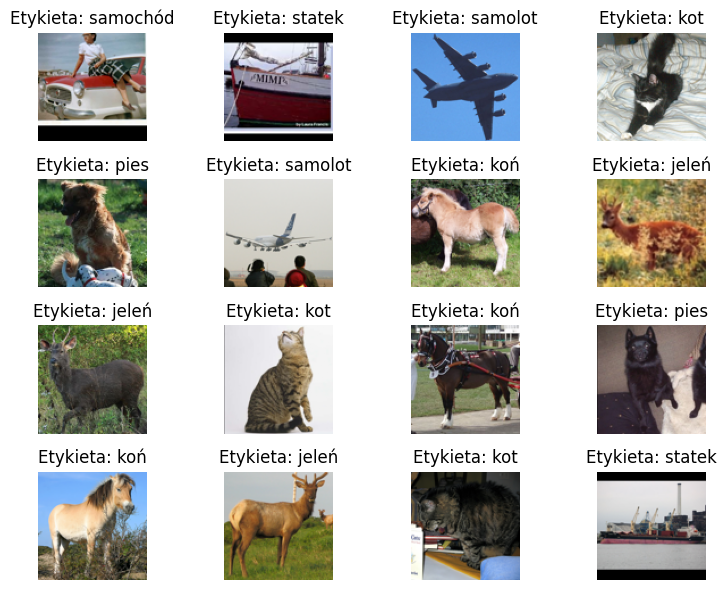

In [11]:
import torch
import matplotlib.pyplot as plt

# Assuming 'data_list' is your list of tuples with (image_tensor, label)
data_list = samples  # your list of 16 (image, label) tuples

# Number of images you want per row in your grid
images_per_row = 4

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(nrows=len(data_list) // images_per_row, ncols=images_per_row, figsize=(8, 6))
axes = axes.flatten()  # Flatten the array of axes if it's multidimensional

for idx, (img_tensor, label) in enumerate(data_list):
    ax = axes[idx]
    # Convert the image tensor to numpy array and make sure its shape is (H, W, C)
    img = img_tensor.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    ax.imshow(img)
    ax.axis('off')  # Hide axes
    ax.set_title(f'Etykieta: {idx_to_label[label]}')

# Adjust subplot parameters to reduce space between images
plt.subplots_adjust(wspace=0.0, hspace=0.0)  # Adjust these values as needed for your layout

plt.tight_layout()
plt.show()


In [12]:
import pandas as pd

In [13]:
acc_path = "../experiments/val_acc"
loss_path = "../experiments/val_loss"

In [14]:
# ae = "lightning_logs_ae-linear.csv"
# flow = "lightning_logs_latent-flow-linear.csv"
# flow_l = "lightning_logs_latent-flow-large-linear.csv"
flow_l = "lightning_logs_latent-flow-large-linear-2.csv"

In [15]:
# ae_linear_acc = pd.read_csv(f"{acc_path}/{ae}")
# flow_linear_acc = pd.read_csv(f"{acc_path}/{flow}")
flow_l_linear_acc = pd.read_csv(f"{acc_path}/{flow_l}")

In [16]:
# ae_linear_loss = pd.read_csv(f"{loss_path}/{ae}")
# flow_linear_loss = pd.read_csv(f"{loss_path}/{flow}")
flow_l_linear_loss = pd.read_csv(f"{loss_path}/{flow_l}")

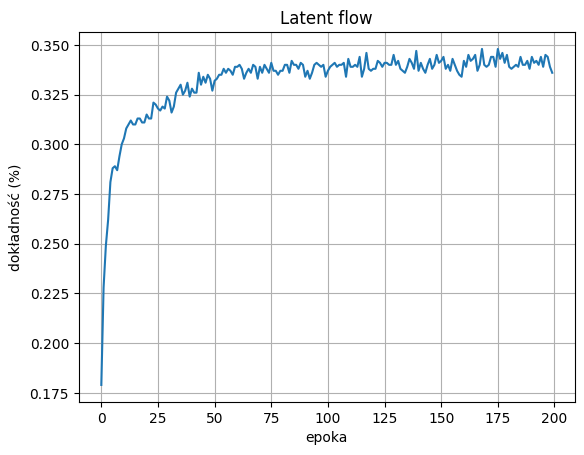

In [20]:
# plt.plot(ae_linear_acc["Value"], label="autokoder")
# plt.plot(flow_linear_acc["Value"], label="flow")
plt.plot(flow_l_linear_acc["Value"])
plt.title("Latent flow")
plt.grid()
plt.xlabel("epoka")
plt.ylabel("dokładność (%)")
plt.show()

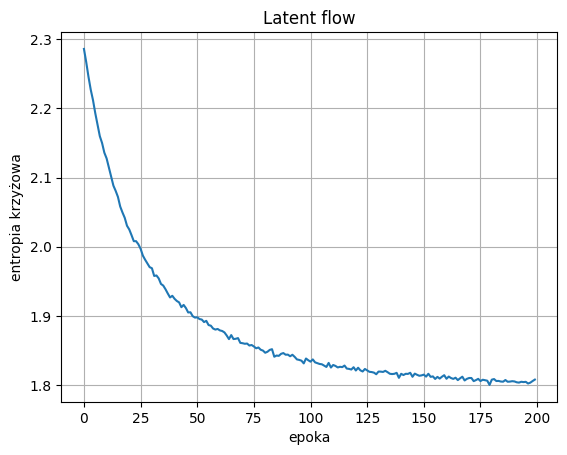

In [22]:
# plt.plot(ae_linear_loss["Value"], label="autokoder")
# plt.plot(flow_linear_loss["Value"], label="flow")
plt.plot(flow_l_linear_loss["Value"])
plt.title("Latent flow")
plt.grid()
plt.xlabel("epoka")
plt.ylabel("entropia krzyżowa")
plt.show()

In [24]:
recon = pd.read_csv("../experiments/lightning_logs_latent-flow-large-pretraining-2.csv")

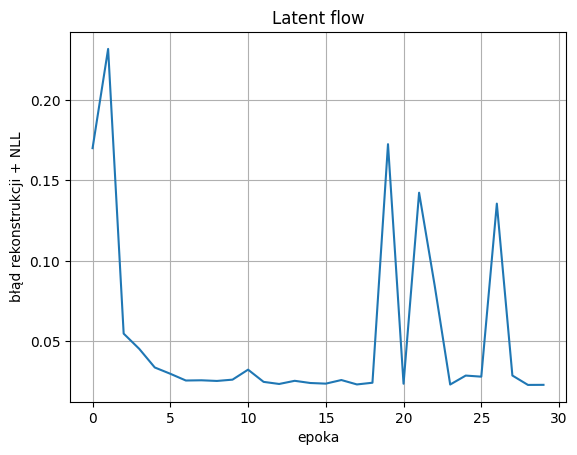

In [28]:
# plt.plot(ae_linear_acc["Value"], label="autokoder")
# plt.plot(flow_linear_acc["Value"], label="flow")
plt.plot(recon["Value"][:30])
plt.title("Latent flow")
plt.grid()
plt.xlabel("epoka")
plt.ylabel("błąd rekonstrukcji + NLL")
plt.show()